In [2]:
import dropbox
from dropbox import DropboxOAuth2FlowNoRedirect

APP_KEY = "qi3onmgezlr00yv"
auth_flow = DropboxOAuth2FlowNoRedirect(APP_KEY, use_pkce=True, token_access_type='offline')

authorize_url = auth_flow.start()
print("1. Go to: " + authorize_url)
print("2. Click \"Allow\" (you might have to log in first).")
print("3. Copy the authorization code.")
auth_code = input("Enter the authorization code here: ").strip()

try:
    oauth_result = auth_flow.finish(auth_code)
except Exception as e:
    print('Error: %s' % (e,))
    exit(1)

with dropbox.Dropbox(oauth2_refresh_token=oauth_result.refresh_token, app_key=APP_KEY) as dbx:
    dbx.users_get_current_account()
    print("Successfully set up client!")

1. Go to: https://www.dropbox.com/oauth2/authorize?response_type=code&client_id=qi3onmgezlr00yv&token_access_type=offline&code_challenge=dDb8Eg1fr0VNFXlokG1NRrrDtHc1pCugvsp0nTh40n8&code_challenge_method=S256
2. Click "Allow" (you might have to log in first).
3. Copy the authorization code.
Successfully set up client!


In [3]:
print(oauth_result.refresh_token)

b_N3-an_VvQAAAAAAAAAAc7kTAMBxeYC9GlsLpwgFrXX3kbZr2li3f3GfGx-iGnr


In [3]:
import dropbox
import numpy as np
from io import BytesIO

APP_KEY = 'qi3onmgezlr00yv'
REFRESH_TOKEN = 'b_N3-an_VvQAAAAAAAAAAc7kTAMBxeYC9GlsLpwgFrXX3kbZr2li3f3GfGx-iGnr'

def get_access_token():
    dbx = dropbox.Dropbox(oauth2_refresh_token=REFRESH_TOKEN, app_key=APP_KEY)
    return dbx

def load_npy_from_dropbox(file_path):
    dbx = get_access_token()
    
    try:
        # Dropbox 파일을 다운로드 (파일 내용을 메모리로 가져옴)
        metadata, res = dbx.files_download(file_path)
        
        # 파일 내용을 NumPy 배열로 변환 (BytesIO로 메모리 스트림 사용)
        file_stream = BytesIO(res.content)
        np_array = np.load(file_stream)
        
        return np_array

    except dropbox.exceptions.ApiError as err:
        print(f'Error: {err}')
        return None


In [8]:
file_path = '/Motion_data_whole_notrans_flair_0922/brain_AXFLAIR_200_6002435_motion.npy'
file_path2 = '/Motion_data_whole_notrans_flair_0922/brain_AXFLAIR_200_6002442_motion.npy'

Image = load_npy_from_dropbox(file_path)
print(Image.shape)
Image2 = load_npy_from_dropbox(file_path2)
print(Image2.shape)

(16, 16, 640, 320)
(16, 16, 640, 320)


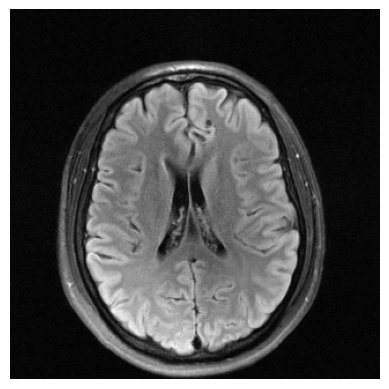

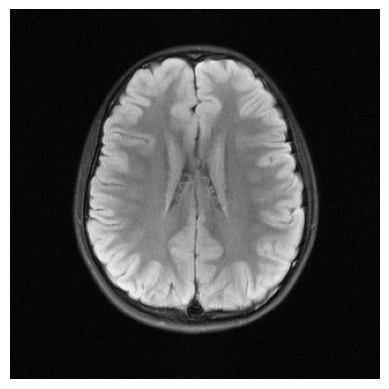

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def crop(img, crop_size=320):
    height, width = img.shape[-2:]
    w_from = (width - crop_size) // 2
    w_to = w_from + crop_size
    h_from = (height - crop_size) // 2
    h_to = h_from + crop_size

    return img[:, :, h_from:h_to, w_from:w_to]

def rss_coil_combine(image):
    squared_abs = np.abs(image)**2
    sum_of_squares = np.sum(squared_abs, axis=1)
    combined_images = np.sqrt(sum_of_squares)
    return combined_images

plt.imshow(rss_coil_combine(crop(Image))[2], cmap='gray', origin='lower'),plt.axis('off')
plt.show()
plt.imshow(rss_coil_combine(crop(Image2))[5], cmap='gray', origin='lower'),plt.axis('off')
plt.show()

In [15]:
filepath = '/MotionParam_apply_whole_notrans_flair_0922/brain_AXFLAIR_200_6002435_018_S_4257.npy'

file = load_npy_from_dropbox(filepath)
print(file.shape)

(5120, 6)
